# Fine tuning a multiclass classification BERT model

**Description:** Fine-tuning of a multiclass classification using BERT-based models. 


1. Setup

  1.1 Libraries & Helper Functions

  1.2 Data Acquisition

  1.3 Training/Test/Validation Sets for BERT-based models

2. Classification with a fine tuned BERT model

  2.1 Create the specified BERT model

  2.2 Fine tune the BERT model as directed

  2.3 Examine the predictions with various metrics

3. Classification using two stages

  3.1 Relabel the data to group the often confused classes

  3.2 Train the first stage model on the relabeled data

  3.3 Separate the data for just the confused classes

  3.4 Train the second stage model on the two classes

  3.5 Combine and evaluate the predictions from the two stages

4. Look at examples of misclassifications, see what might have changed


### 1. Setup

Get our libraries, download and process our data.

In [22]:
#!pip install -q transformers
!pip install -q transformers==4.37.2

In [23]:
!pip install pydot

In [24]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [25]:
from collections import Counter
import numpy as np
import tensorflow as tf
from tensorflow import keras

import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint

In [26]:
from transformers import BertTokenizer, TFBertModel

We're going to use the 20 newsgroups dataset. It includes posts from 20 different newsgroups. 

In [27]:
def read_20newsgroups(test_size=0.1):
  # download & load 20newsgroups dataset from sklearn's repos
  dataset = fetch_20newsgroups(subset="all", shuffle=True, remove=("headers", "footers", "quotes"))
  documents = dataset.data
  labels = dataset.target
  # split into training & testing a return data as well as label names
  return train_test_split(documents, labels, test_size=test_size), dataset.target_names

# call the function
(train_texts, test_texts, train_labels, test_labels), target_names = read_20newsgroups()

We have a long string of text and an associated label.  That label is the Usenet group where the posting occured. The records are the raw text.  

In [28]:
train_texts[:2]

['\n\n\n   I agree. I also think Roy needs a good kick sometimes...that horrible\n4-0 loss to the Capitals last week...yeeeech!\n\n   Here\'s to Cup #23...this year!\n\n \n-- \nRichard J. Rauser        "You have no idea what you\'re doing."\nrauser@sfu.ca            "Oh, don\'t worry about that. We\'re professional\nWNI                          outlaws - we do this for a living."',
 " \n \n  That's true, but according to your stats, Chicago has just as good a\nrecord as Toronto.  It's interesting that you should list Toronto ahead\nof Chicago."]

In [29]:
train_labels[:2]

array([10, 10])

The variable ''target_names'' stores all of the names of the labels.

In [30]:
print(target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


We already have a test set and a train set, setting aside part of the training set for validation.

In [31]:
#len(train_texts)
valid_texts = train_texts[16000:]
valid_labels = train_labels[16000:]
train_texts = train_texts[:16000]
train_labels = train_labels[:16000]

The validation set has 961 records.

In [32]:
len(valid_texts)

961

The training set has 16000 records.

In [33]:
len(train_texts)

16000

In [34]:
#get the labels in a needed data format for validation
npvalid_labels = np.asarray(valid_labels)

variables defined for the data:

* train_texts - an array of text strings for training
* test_texts - an array of text strings for testing
* valid texts - an array of text strings for validation
* train_labels - an array of integers representing the labels associated with train_texts
* test_labels - an array of integers representing the labels associated with test_texts
* valid_labels - an array of integers representing the labels associated with valid_texts
* target_names - an array of label strings that correspond to the integers in the *_labels arrays

### 2. Classification with a fine tuned BERT model

base BERT model with cased version to account for capital and lower case letters.

In [35]:
#make it easier to use a variety of BERT subword models
model_checkpoint = 'bert-base-cased'

In [36]:
bert_tokenizer = BertTokenizer.from_pretrained(model_checkpoint)
bert_model = TFBertModel.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

The maximum training record length is 200. 

In [37]:
max_length = 200

tokenize the three data slices. 

In [38]:
# tokenize the dataset, truncate at `max_length`,
# pad with 0's when less than `max_length` and return a tf Tensor
train_encodings = bert_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = bert_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = bert_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')

In [39]:
train_encodings.input_ids[:1]

<tf.Tensor: shape=(1, 200), dtype=int32, numpy=
array([[  101,   146,  5340,   119,   146,  1145,  1341,  5396,  2993,
          170,  1363,  5642,  2121,   119,   119,   119,  1115,  9210,
          125,   118,   121,  2445,  1106,  1103,  6299,  1116,  1314,
         1989,   119,   119,   119,  6798,  3051, 11252,   106,  3446,
          112,   188,  1106,  1635,   108,  1695,   119,   119,   119,
         1142,  1214,   106,   118,   118,  2055,   147,   119, 16890,
        19399,   107,  1192,  1138,  1185,  1911,  1184,  1128,   112,
         1231,  1833,   119,   107,   187, 25134,  1200,   137,   188,
        14703,   119, 11019,   107,  2048,   117,  1274,   112,   189,
         3994,  1164,  1115,   119,  1284,   112,  1231,  1848,   160,
        27451,  1149, 17830,   118,  1195,  1202,  1142,  1111,   170,
         1690,   119,   107,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0, 

A function for this multiclass bert model.


* Each record can have one of n labels where n = the size of target_names.
* Want a hidden size layer of size 201
* Want our hidden layer to make use of the **pooler output** from BERT
* Want to use dropout
* Our classification layer needs is appropriately sized and use the correct non-linearity for a multi-class problem.
* For multiple label we change our loss metric to a categorical cross entropy.  
* Training to affect **all** of the layers in BERT.


In [40]:
def create_bert_multiclass_model(checkpoint = model_checkpoint,
                                 num_classes = 20,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    
    bert_model = TFBertModel.from_pretrained(checkpoint)
    bert_model.trainable = True

    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')


    output = bert_model(input_ids, token_type_ids = token_type_ids, attention_mask = attention_mask)

    #output embeddings of the [CLS] token
    pooler_output = output.pooler_output

    # pass the pooler_output to a hidden layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(pooler_output)

    # add dropout layer
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # add the classification layerand activation function
    classification_output = tf.keras.layers.Dense(num_classes, activation='softmax')(hidden)

    # build the model
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=classification_output)

    # Compile the model with categorical crossentropy loss for multiclass classification
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                                 metrics=['accuracy'])










    
    return classification_model

In [41]:
pooler_bert_model = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=20)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [42]:
pooler_bert_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids_layer (InputLaye  [(None, None)]               0         []                            
 r)                                                                                               
                                                                                                  
 attention_mask_layer (Inpu  [(None, None)]               0         []                            
 tLayer)                                                                                          
                                                                                                  
 token_type_ids_layer (Inpu  [(None, None)]               0         []                            
 tLayer)                                                                                    

**QUESTION:** 2.1 How many trainable parameters are in your dense hidden layer?154569

**QUESTION:** 2.2 How many trainable parameters are in your classification layer?4040

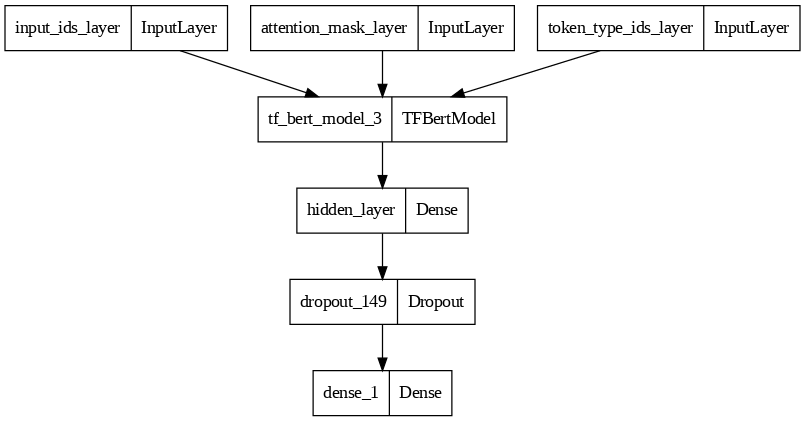

In [43]:
keras.utils.plot_model(pooler_bert_model, show_shapes=False, show_dtype=False, show_layer_names=True, dpi=90)

In [44]:
#It takes 10 to 14 minutes to complete an epoch when using a GPU
pooler_bert_model_history = pooler_bert_model.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                  npvalid_labels),
                                                  batch_size=8,
                                                  epochs=1)

2000/2000 [==============================] - 761s 361ms/step - loss: 1.5828 - accuracy: 0.5193 - val_loss: 1.1004 - val_accuracy: 0.6785


Evaluate against our fine-tuned model, for an overall accuracy based on the test set.

In [45]:
#eval b=8 e=1 dim=201
score = pooler_bert_model.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

59/59 [==============================] - 24s 408ms/step - loss: 1.0948 - accuracy: 0.6743
Test loss: 1.0948221683502197
Test accuracy: 0.6742705702781677


Test accuracy score 0.677

In [46]:
#running predict for the first three elements in the test data set
predictions = pooler_bert_model.predict([test_encodings.input_ids[:3], test_encodings.token_type_ids[:3], test_encodings.attention_mask[:3]])

1/1 [==============================] - 3s 3s/step


In [47]:
predictions

array([[1.8153086e-01, 2.0184540e-03, 1.1198741e-03, 6.8137900e-04,
        4.0296710e-04, 3.4703151e-04, 8.2223467e-04, 9.5417653e-04,
        1.1638169e-03, 2.6394913e-03, 1.3225628e-03, 3.0012587e-03,
        1.1242534e-03, 4.0901909e-03, 4.4524148e-03, 5.1366645e-01,
        5.2269753e-03, 4.9078777e-03, 1.5235124e-03, 2.6900420e-01],
       [1.5610310e-03, 2.0093548e-03, 1.7675756e-04, 3.7135187e-04,
        6.5085868e-04, 2.8163093e-04, 2.4179553e-03, 1.2206965e-02,
        9.7156930e-01, 6.4315047e-04, 7.2720653e-04, 2.6149541e-04,
        2.9055090e-04, 7.9714420e-04, 1.6376229e-03, 3.9250377e-04,
        1.3745335e-03, 3.1794369e-04, 9.1249199e-04, 1.4000568e-03],
       [4.0526712e-01, 1.0444791e-03, 1.0131373e-03, 6.1662361e-04,
        7.0250320e-04, 2.3003329e-04, 9.9526322e-04, 1.5305564e-03,
        7.9322176e-04, 2.3467131e-03, 1.3741766e-03, 2.4406668e-03,
        9.7391632e-04, 2.6117146e-03, 1.8122497e-03, 3.2406732e-01,
        5.9094736e-03, 1.2639795e-02, 3.240849

In [48]:
#run and capture all predictions from our test set using model.predict

predictions_model1 = pooler_bert_model.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])


#now we need to get the highest probability in the distribution for each prediction
#and store that in a tf.Tensor
predictions_model1 = tf.argmax(predictions_model1, axis=-1)
predictions_model1

59/59 [==============================] - 24s 412ms/step


<tf.Tensor: shape=(1885,), dtype=int64, numpy=array([15,  8,  0, ...,  3,  3, 18])>

We need to make sure that each of our categories' prediction performance is operating at an equal or higher level than the overall.

Use the classification report from scikit learn:  ground truth (y_true), associated prediction (y_pred).  

In [49]:
print(classification_report(test_labels, predictions_model1.numpy(), target_names=target_names))

                          precision    recall  f1-score   support

             alt.atheism       0.45      0.47      0.46        87
           comp.graphics       0.64      0.55      0.59       108
 comp.os.ms-windows.misc       0.60      0.60      0.60       100
comp.sys.ibm.pc.hardware       0.50      0.73      0.59       100
   comp.sys.mac.hardware       0.79      0.52      0.63        92
          comp.windows.x       0.82      0.79      0.81        97
            misc.forsale       0.78      0.72      0.75        86
               rec.autos       0.49      0.77      0.60        90
         rec.motorcycles       0.76      0.62      0.68       106
      rec.sport.baseball       0.87      0.84      0.86       107
        rec.sport.hockey       0.93      0.84      0.88       100
               sci.crypt       0.65      0.71      0.68       103
         sci.electronics       0.56      0.61      0.58       107
                 sci.med       0.90      0.75      0.81       106
         

visualization for classifier: confusion matrix.

In [50]:
cm = tf.math.confusion_matrix(test_labels, predictions_model1)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

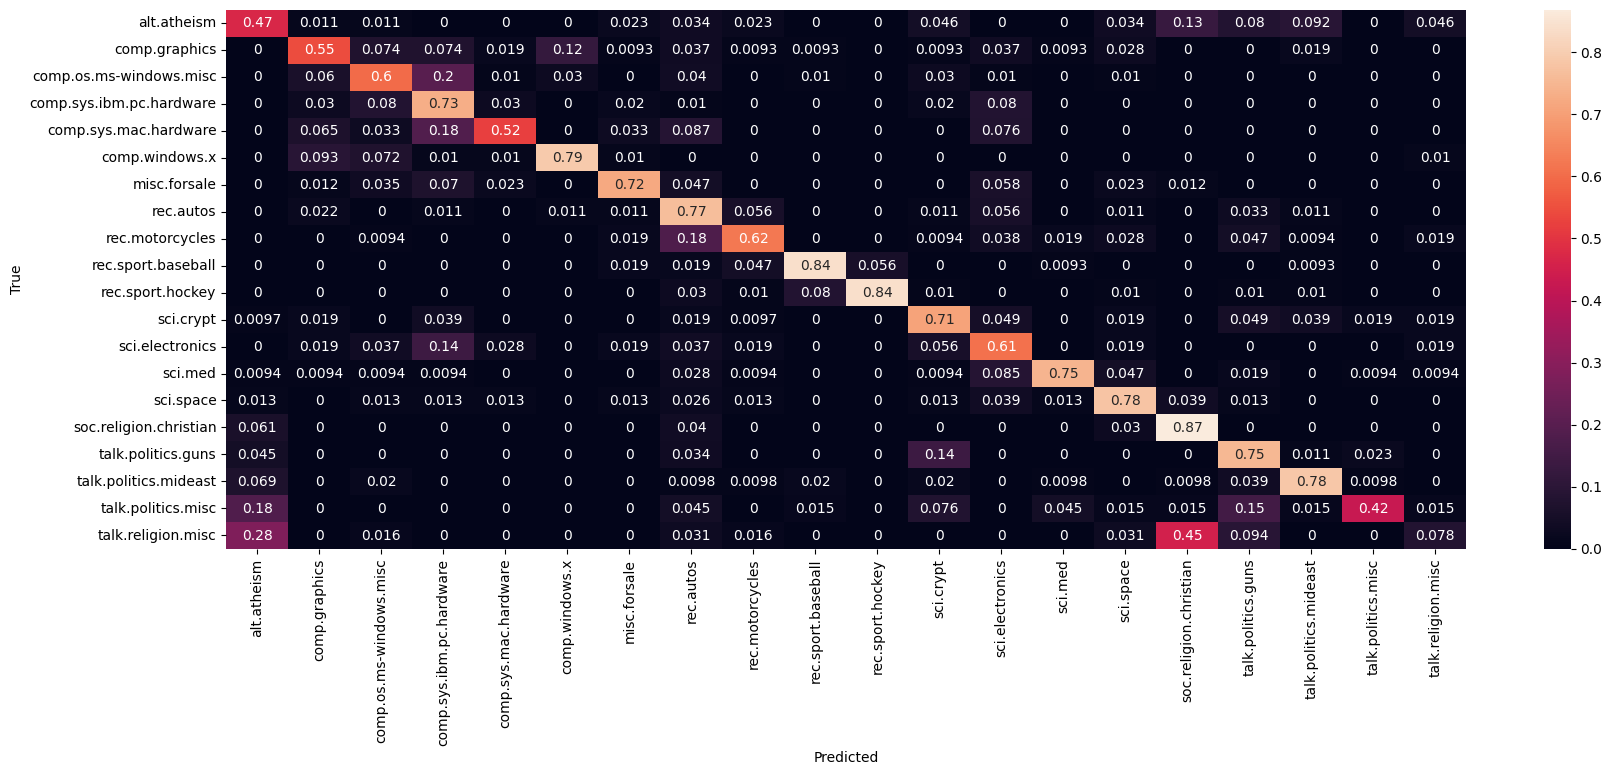

In [51]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### 3. Classification using two stages

Train a series of models, to separate groups of classes, then use more specialized sub-models to classify only a subset of the classes. 

#### Step 1: New model with 19 classes

Combine two categories in our first step. Replace the label of the last class with the label of the class it's most often mistaken for. 

In [52]:
label_to_replace = 19

# label_to_replace_with = ...

label_to_replace_with = 15



train_labels_19class = train_labels.copy()
train_labels_19class[train_labels_19class == label_to_replace] = label_to_replace_with

valid_labels_19class = npvalid_labels.copy()
valid_labels_19class[valid_labels_19class == label_to_replace] = label_to_replace_with

test_labels_19class = test_labels.copy()
test_labels_19class[test_labels_19class == label_to_replace] = label_to_replace_with

Create a new model with the same architecture, but to predict probabilities for 19 classes instead of 20. 

In [53]:
bert_model_19class = create_bert_multiclass_model(checkpoint = model_checkpoint, num_classes=19)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [54]:
bert_model_19class_history = bert_model_19class.fit([train_encodings.input_ids, train_encodings.token_type_ids, train_encodings.attention_mask],
                                                  train_labels_19class,
                                                  validation_data=([valid_encodings.input_ids, valid_encodings.token_type_ids, valid_encodings.attention_mask],
                                                                   valid_labels_19class),
                                                  batch_size=8,
                                                  epochs=1)

2000/2000 [==============================] - 774s 366ms/step - loss: 1.3999 - accuracy: 0.5795 - val_loss: 1.0268 - val_accuracy: 0.6961


In [55]:
#Evaluate the fine tuned 19-class model against the test data with 19-class labels

score = bert_model_19class.evaluate([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask],
                                                  test_labels_19class)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

59/59 [==============================] - 26s 445ms/step - loss: 0.9941 - accuracy: 0.7024
Test loss: 0.9941206574440002
Test accuracy: 0.702387273311615


In [60]:
#run and capture all the predictions from the 19 class data

predictions_19class = bert_model_19class.predict([test_encodings.input_ids, test_encodings.token_type_ids, test_encodings.attention_mask])
predictions_19class = tf.argmax(predictions_19class, axis=-1)


predictions_19class

59/59 [==============================] - 27s 454ms/step


<tf.Tensor: shape=(1885,), dtype=int64, numpy=array([15,  8, 15, ...,  4,  3, 18])>

In [61]:
target_names_19class = target_names[:label_to_replace_with] \
                     + ['** COMBINED CLASS **'] \
                     + target_names[label_to_replace_with+1:19]

print(classification_report(test_labels_19class, predictions_19class.numpy(),
                            target_names=target_names_19class))

                          precision    recall  f1-score   support

             alt.atheism       0.58      0.46      0.51        87
           comp.graphics       0.62      0.61      0.62       108
 comp.os.ms-windows.misc       0.44      0.68      0.54       100
comp.sys.ibm.pc.hardware       0.52      0.75      0.61       100
   comp.sys.mac.hardware       0.62      0.65      0.63        92
          comp.windows.x       0.82      0.77      0.79        97
            misc.forsale       0.88      0.83      0.85        86
               rec.autos       0.62      0.72      0.67        90
         rec.motorcycles       0.83      0.56      0.67       106
      rec.sport.baseball       0.90      0.87      0.89       107
        rec.sport.hockey       0.81      0.92      0.86       100
               sci.crypt       0.88      0.64      0.74       103
         sci.electronics       0.66      0.49      0.56       107
                 sci.med       0.88      0.75      0.81       106
         

#### Step 2: New model with only the two classes combined in step one

First stage model is able to determine which text is one of the two often confused classes, but we need to train a more specific model to distinguish between just these two classes.

For this model, we'll only train using the text examples from the two confused categories. 

In [62]:
train_mask_2class = (train_labels_19class == label_to_replace_with)
train_encodings_2class = {'input_ids': train_encodings.input_ids[train_mask_2class],
                          'token_type_ids': train_encodings.token_type_ids[train_mask_2class],
                          'attention_mask': train_encodings.attention_mask[train_mask_2class]}
train_labels_2class = train_labels.copy()[train_mask_2class]
train_labels_2class = (train_labels_2class == label_to_replace_with).astype(int)

valid_mask_2class = (valid_labels_19class == label_to_replace_with)
valid_encodings_2class = {'input_ids': valid_encodings.input_ids[valid_mask_2class],
                          'token_type_ids': valid_encodings.token_type_ids[valid_mask_2class],
                          'attention_mask': valid_encodings.attention_mask[valid_mask_2class]}
valid_labels_2class = npvalid_labels.copy()[valid_mask_2class]
valid_labels_2class = (valid_labels_2class == label_to_replace_with).astype(int)

test_mask_2class = (test_labels_19class == label_to_replace_with)
test_encodings_2class = {'input_ids': test_encodings.input_ids[test_mask_2class],
                          'token_type_ids': test_encodings.token_type_ids[test_mask_2class],
                          'attention_mask': test_encodings.attention_mask[test_mask_2class]}
test_labels_2class = test_labels.copy()[test_mask_2class]
test_labels_2class = (test_labels_2class == label_to_replace_with).astype(int)

In [ ]:
train_labels_2class.shape

In [64]:
train_labels_2class

array([1, 0, 1, ..., 1, 0, 1])

Create and train a new model with the same architecture, except to predicts two classes. 

In [65]:
bert_model_2class = create_bert_multiclass_model(checkpoint=model_checkpoint, num_classes=2)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [66]:
bert_model_2class_history = bert_model_2class.fit([train_encodings_2class['input_ids'],
                                                   train_encodings_2class['token_type_ids'],
                                                   train_encodings_2class['attention_mask']],
                                                  train_labels_2class,
                                                  validation_data=([valid_encodings_2class['input_ids'],
                                                                    valid_encodings_2class['token_type_ids'],
                                                                    valid_encodings_2class['attention_mask']],
                                                                   valid_labels_2class),
                                                  batch_size=8,
                                                  epochs=1)

174/174 [==============================] - 132s 408ms/step - loss: 0.7186 - accuracy: 0.6183 - val_loss: 0.6072 - val_accuracy: 0.6711


In [67]:
#Evaluate the two-class model against the two-class test set.

score = bert_model_2class.evaluate([test_encodings_2class['input_ids'],
                                    test_encodings_2class['token_type_ids'],
                                    test_encodings_2class['attention_mask']],
                                   test_labels_2class)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

6/6 [==============================] - 2s 362ms/step - loss: 0.5951 - accuracy: 0.7178
Test loss: 0.5950523614883423
Test accuracy: 0.7177914381027222


In [68]:
#run and capture all the predictions from the 2-class test data

predictions_2class = bert_model_2class.predict([test_encodings_2class['input_ids'],
                                    test_encodings_2class['token_type_ids'],
                                    test_encodings_2class['attention_mask']])
predictions_2class= tf.argmax(predictions_2class, axis=-1)

predictions_2class

6/6 [==============================] - 6s 355ms/step


<tf.Tensor: shape=(163,), dtype=int64, numpy=
array([0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1])>

In [69]:
# Run the sklearn classification_report again with the 2-class predictions

report = classification_report(test_labels_2class, predictions_2class, target_names=['soc.religion.christian', 'talk.religion.misc'])


print(report)


                        precision    recall  f1-score   support

soc.religion.christian       0.75      0.42      0.54        64
    talk.religion.misc       0.71      0.91      0.80        99

              accuracy                           0.72       163
             macro avg       0.73      0.67      0.67       163
          weighted avg       0.72      0.72      0.70       163



#### Step 3: Combine the predicted labels from the two steps

We start with the predictions from the first step.

Where the first model predicted the combined category, we replace the predictions with the label from the second model. 

In [70]:
# Now get the examples that the first model predicted as in the combined class
test_mask_2class = (predictions_19class.numpy() == label_to_replace_with)
test_encodings_2class = {'input_ids': test_encodings.input_ids[test_mask_2class],
                         'token_type_ids': test_encodings.token_type_ids[test_mask_2class],
                         'attention_mask': test_encodings.attention_mask[test_mask_2class]}

# Run those examples through the step 2 model and save the predictions
predictions_2class = bert_model_2class.predict([test_encodings_2class['input_ids'],
                                                test_encodings_2class['token_type_ids'],
                                                test_encodings_2class['attention_mask']],)
predictions_2class = tf.argmax(predictions_2class, axis=-1)

# Replace the step 2 model's predicted labels with the original values from the 20-class dataset
predictions_2class = predictions_2class.numpy()
predictions_2class[predictions_2class == 0] = label_to_replace
predictions_2class[predictions_2class == 1] = label_to_replace_with

# Combine the labels from both steps for the full test dataset
predictions_2steps = predictions_19class.numpy()
predictions_2steps[test_mask_2class] = predictions_2class

predictions_2steps

6/6 [==============================] - 2s 362ms/step


array([15,  8, 15, ...,  4,  3, 18])

The classification report and confusion matrix, using the combined predictions from the two step model: 

In [71]:
# sklearn classification_report with all 20 classes from the 2-step predictions


report = classification_report(test_labels, predictions_2steps, target_names = target_names)
print(report)


                          precision    recall  f1-score   support

             alt.atheism       0.58      0.46      0.51        87
           comp.graphics       0.62      0.61      0.62       108
 comp.os.ms-windows.misc       0.44      0.68      0.54       100
comp.sys.ibm.pc.hardware       0.52      0.75      0.61       100
   comp.sys.mac.hardware       0.62      0.65      0.63        92
          comp.windows.x       0.82      0.77      0.79        97
            misc.forsale       0.88      0.83      0.85        86
               rec.autos       0.62      0.72      0.67        90
         rec.motorcycles       0.83      0.56      0.67       106
      rec.sport.baseball       0.90      0.87      0.89       107
        rec.sport.hockey       0.81      0.92      0.86       100
               sci.crypt       0.88      0.64      0.74       103
         sci.electronics       0.66      0.49      0.56       107
                 sci.med       0.88      0.75      0.81       106
         

In [72]:
cm = tf.math.confusion_matrix(test_labels, predictions_2steps)
cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

Text(220.72222222222223, 0.5, 'True')

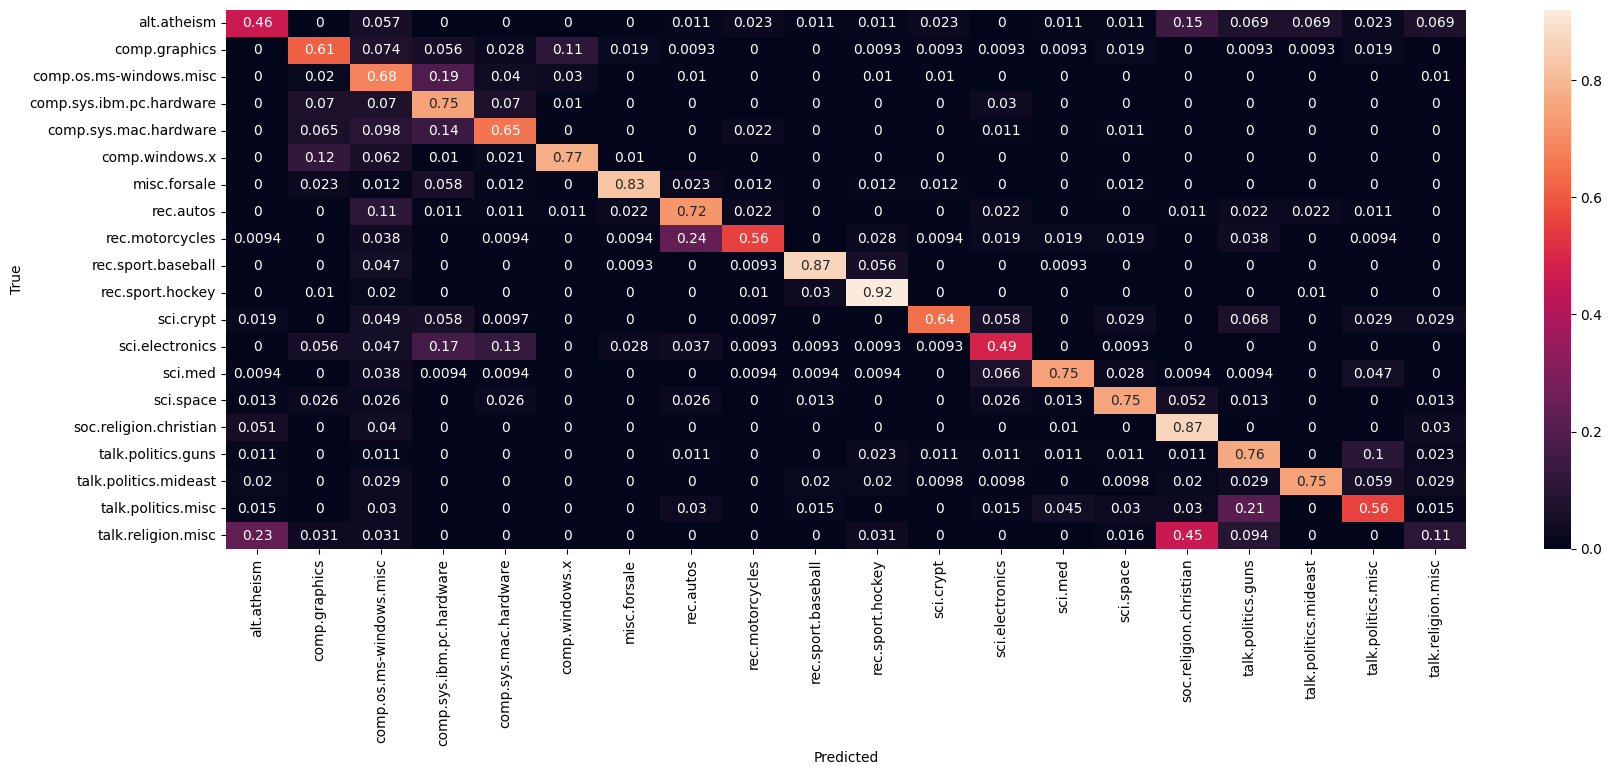

In [73]:
plt.figure(figsize=(20,7))
sns.heatmap(
    cm, annot=True,
    xticklabels=target_names,
    yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")

### Look at examples of misclassifications



In [74]:
# Make a vector the length of our test set, with 1 if the second model predicted the
# "label_to_replace_with" class, and 0s otherwise
select_predictions = (predictions_2steps == label_to_replace_with)


In [75]:
# Now only keep a 1 if that was not the correct label, i.e. it was a false positive
select_predictions = select_predictions * (test_labels != label_to_replace_with)

In [76]:
# And now only keep a 1 if the original model predicted the correct label instead
select_predictions = select_predictions * (test_labels == predictions_model1.numpy())

In [77]:
# Print out the original and clean text of the examples that met the above conditions
for i in np.where(select_predictions)[0]:

    print('Prediction: model1 = %s, model2 = %s):\nText: %s\n\n' %
          (target_names[predictions_model1[i]],
           target_names[predictions_2steps[i]],
           test_texts[i][:1000].replace('\n', ' ')))

Prediction: model1 = alt.atheism, model2 = soc.religion.christian):
Text:  Yes, worshipping Jesus as the super-saver is indeed hero-worshipping of the grand scale. Worshipping Lenin that will make life pleasant for the working people is, eh, somehow similar, or what.   The notion of Lenin was on the borderline of supernatural insights into how to change the world, he wasn't a communist God, but he was the man who gave presents to kids during Christmas.    Don't know what they were, but they were fanatics indeed.  Cheers, Kent


Prediction: model1 = sci.space, model2 = soc.religion.christian):
Text:           Let us hope that the performance of the spacecraft follows the sentiments of the first verse (miner) rather than the second (lost and gone forever). 


Prediction: model1 = alt.atheism, model2 = soc.religion.christian):
Text: .d. .d. I just thought of another one, in the Bible, so it's definately not because of *lack* of religion.  The Book of Esther (which I read the other day for